In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, KFold, ShuffleSplit
from sklearn.metrics import make_scorer
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn import pipeline
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression

# Немного посмотрел данные

Ник на kaggle - Vanguard

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [615]:
data.isna().sum() #Пропусков нет, круто

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [616]:
mask = data['TotalSpent'].apply(lambda x: x == ' ') #находим пробелы в Total spent (без исправления потом будут всплывать ошибки)
#далее их убираем
data['TotalSpent'] = data['TotalSpent'].str.replace(' ', '0', regex=False)

абсолютно бесполезный показатель )

<AxesSubplot:xlabel='Sex', ylabel='count'>

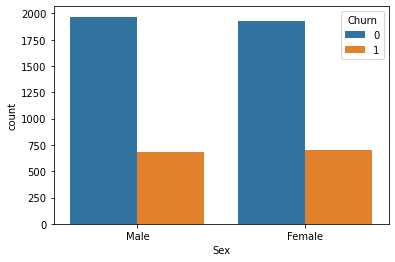

In [569]:
sns.countplot(x="Sex", data=data, hue='Churn') # Остальные смотрел, ничего особого

In [572]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [617]:
# видно, что числовой TotalSpent является object, нужно пофиксить
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])

До этого я пробовал различные модели, комбинации, убирал некоторые фичи, но результата какого-то особого я не получил. 
Поэтому я сделал пайплайн и выбирал из логистической регрессии, xgboost и catboost, как самые подходящие для задачи классификации. Фичи не стал никакие убирать, тем более для бустеров это не так важно, а в логистической можно добавить регуляризаторы.

# Pipeline check

Изначально я лишь меняю тип колонки TotalSpent и убираю пробелы. Далее откладываю 20% для теста модели. В пайплайне категориальные фичи преобразую с помощью OneHotEncoding, а непрерывные нормирую

In [5]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data['TotalSpent'] = data['TotalSpent'].str.replace(' ', '0', regex=False)
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])

test['TotalSpent'] = test['TotalSpent'].str.replace(' ', '0', regex=False)
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'])

num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent',
    'IsSeniorCitizen' #добавил сюда, чтобы не менять, она и так в норм формате
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]
X_train, X_test, y_train, y_test = train_test_split(data[cat_cols+num_cols], data['Churn'], train_size=0.8, random_state=42)

In [7]:
xgb = xgboost.XGBClassifier(objective = 'binary:logistic', eval_metric='auc', booster='gbtree')
xgb_params = {'model__n_estimators': stats.randint(50, 5000),
              "model__colsample_bytree": stats.uniform(0.2, 0.9),
              'model__learning_rate': stats.uniform(0.01, 0.3),
              'model__subsample': stats.uniform(0.2, 0.8),
              'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'model__colsample_bytree': stats.uniform(0.2, 0.9),
              'model__min_child_weight': [1, 2, 3, 4,5, 6],
              "model__gamma": [0, 0.1, 0.3,0.4,0.5]
             }

lr = LogisticRegression()
lr_params = {'model__penalty': ['l2', 'l1', 'elasticnet', 'none'],
             'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

catboost = CatBoostClassifier(custom_metric='AUC')
catboost_params = {'model__learning_rate': stats.uniform(0.01, 0.6),
              'model__l2_leaf_reg': stats.randint(1, 300),
              'model__iterations': stats.randint(50, 1000),
              'model__depth': [2, 3, 4, 5, 6, 7, 8, 9],
              'model__loss_function': ['Logloss', 'CrossEntropy'],
              'model__border_count': stats.randint(1, 255),
              'model__bootstrap_type': ['Bayesian', 'Bernoulli'],
              'model__min_data_in_leaf': stats.randint(1, 10)}

models = [(xgb, xgb_params), (lr, lr_params), (catboost, catboost_params)]
classificators = []

for model, params in models:
    pipe = pipeline.Pipeline(steps = [       
        ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
                #numeric
                ('numeric_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', FunctionTransformer(lambda data: data[num_cols])),
                    ('scaling', StandardScaler(with_mean = 0))            
                            ])),

                #categorical
                ('categorical_variables_processing', pipeline.Pipeline(steps = [
                    ('selecting', FunctionTransformer(lambda data: data[cat_cols])),
                    ('hot_encoding', OneHotEncoder(drop='first', handle_unknown = 'error'))            
                            ])),
            ])),
        ('model', model)
        ]
    )

    cv = KFold(n_splits = 5, shuffle = True)
    clf = RandomizedSearchCV(pipe, 
                             n_iter=10,
                             param_distributions = params,
                             cv = cv,  
                             scoring = 'roc_auc',
                             n_jobs = -1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred[:, 1])
    classificators.append(clf)
    print(clf.best_params_)
    print(f"ROC-AUC: {roc_auc}")

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'model__colsample_bytree': 0.6375393564937104, 'model__gamma': 0, 'model__learning_rate': 0.010690483713620183, 'model__max_depth': 10, 'model__min_child_weight': 3, 'model__n_estimators': 3617, 'model__subsample': 0.5400846556729797}
ROC-AUC: 0.797923920170667


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'model__solver': 'lbfgs', 'model__penalty': 'none', 'model__C': 10}
ROC-AUC: 0.826723986664327
0:	learn: 0.6751989	total: 70.4ms	remaining: 54.1s
1:	learn: 0.6611782	total: 73.4ms	remaining: 28.2s
2:	learn: 0.6465763	total: 76.5ms	remaining: 19.6s
3:	learn: 0.6325960	total: 79.3ms	remaining: 15.2s
4:	learn: 0.6208392	total: 82.4ms	remaining: 12.6s
5:	learn: 0.6094564	total: 85.9ms	remaining: 10.9s
6:	learn: 0.5973047	total: 89ms	remaining: 9.7s
7:	learn: 0.5874769	total: 92.5ms	remaining: 8.81s
8:	learn: 0.5769511	total: 96.1ms	remaining: 8.13s
9:	learn: 0.5673471	total: 99.6ms	remaining: 7.57s
10:	learn: 0.5600436	total: 103ms	remaining: 7.12s
11:	learn: 0.5515097	total: 107ms	remaining: 6.74s
12:	learn: 0.5447282	total: 109ms	remaining: 6.37s
13:	learn: 0.5387560	total: 112ms	remaining: 6.06s
14:	learn: 0.5320664	total: 115ms	remaining: 5.77s
15:	learn: 0.5256902	total: 118ms	remaining: 5.55s
16:	learn: 0.5201201	total: 121ms	remaining: 5.35s
17:	learn: 0.5146339	total: 124ms	remain

234:	learn: 0.3981301	total: 573ms	remaining: 1.3s
235:	learn: 0.3980749	total: 575ms	remaining: 1.3s
236:	learn: 0.3980459	total: 577ms	remaining: 1.3s
237:	learn: 0.3979767	total: 579ms	remaining: 1.29s
238:	learn: 0.3979175	total: 582ms	remaining: 1.29s
239:	learn: 0.3978672	total: 584ms	remaining: 1.29s
240:	learn: 0.3978540	total: 586ms	remaining: 1.29s
241:	learn: 0.3978360	total: 589ms	remaining: 1.28s
242:	learn: 0.3977745	total: 591ms	remaining: 1.28s
243:	learn: 0.3977425	total: 593ms	remaining: 1.28s
244:	learn: 0.3976992	total: 595ms	remaining: 1.27s
245:	learn: 0.3976736	total: 598ms	remaining: 1.27s
246:	learn: 0.3976503	total: 600ms	remaining: 1.27s
247:	learn: 0.3975868	total: 602ms	remaining: 1.27s
248:	learn: 0.3975305	total: 604ms	remaining: 1.26s
249:	learn: 0.3974694	total: 605ms	remaining: 1.26s
250:	learn: 0.3973692	total: 607ms	remaining: 1.25s
251:	learn: 0.3973141	total: 609ms	remaining: 1.25s
252:	learn: 0.3972715	total: 611ms	remaining: 1.25s
253:	learn: 0.3

393:	learn: 0.3920834	total: 899ms	remaining: 858ms
394:	learn: 0.3920505	total: 901ms	remaining: 856ms
395:	learn: 0.3920387	total: 904ms	remaining: 853ms
396:	learn: 0.3919991	total: 906ms	remaining: 851ms
397:	learn: 0.3919831	total: 908ms	remaining: 849ms
398:	learn: 0.3919381	total: 910ms	remaining: 846ms
399:	learn: 0.3919140	total: 912ms	remaining: 844ms
400:	learn: 0.3919047	total: 915ms	remaining: 842ms
401:	learn: 0.3918796	total: 916ms	remaining: 839ms
402:	learn: 0.3918444	total: 919ms	remaining: 837ms
403:	learn: 0.3918352	total: 920ms	remaining: 834ms
404:	learn: 0.3917741	total: 922ms	remaining: 831ms
405:	learn: 0.3917520	total: 924ms	remaining: 828ms
406:	learn: 0.3917374	total: 926ms	remaining: 826ms
407:	learn: 0.3916964	total: 928ms	remaining: 824ms
408:	learn: 0.3916531	total: 930ms	remaining: 821ms
409:	learn: 0.3916301	total: 932ms	remaining: 818ms
410:	learn: 0.3915880	total: 934ms	remaining: 816ms
411:	learn: 0.3915444	total: 935ms	remaining: 813ms
412:	learn: 

577:	learn: 0.3869752	total: 1.24s	remaining: 411ms
578:	learn: 0.3869451	total: 1.24s	remaining: 409ms
579:	learn: 0.3869352	total: 1.24s	remaining: 407ms
580:	learn: 0.3869014	total: 1.24s	remaining: 405ms
581:	learn: 0.3868638	total: 1.25s	remaining: 402ms
582:	learn: 0.3868415	total: 1.25s	remaining: 400ms
583:	learn: 0.3868145	total: 1.25s	remaining: 398ms
584:	learn: 0.3867915	total: 1.25s	remaining: 396ms
585:	learn: 0.3867640	total: 1.25s	remaining: 394ms
586:	learn: 0.3867345	total: 1.25s	remaining: 391ms
587:	learn: 0.3867019	total: 1.26s	remaining: 389ms
588:	learn: 0.3866782	total: 1.26s	remaining: 387ms
589:	learn: 0.3866541	total: 1.26s	remaining: 385ms
590:	learn: 0.3866377	total: 1.26s	remaining: 382ms
591:	learn: 0.3866135	total: 1.26s	remaining: 380ms
592:	learn: 0.3865936	total: 1.27s	remaining: 378ms
593:	learn: 0.3865723	total: 1.27s	remaining: 376ms
594:	learn: 0.3865419	total: 1.27s	remaining: 374ms
595:	learn: 0.3865313	total: 1.27s	remaining: 371ms
596:	learn: 

765:	learn: 0.3826567	total: 1.57s	remaining: 8.2ms
766:	learn: 0.3826428	total: 1.57s	remaining: 6.15ms
767:	learn: 0.3826303	total: 1.57s	remaining: 4.1ms
768:	learn: 0.3825951	total: 1.58s	remaining: 2.05ms
769:	learn: 0.3825731	total: 1.58s	remaining: 0us
{'model__bootstrap_type': 'Bayesian', 'model__border_count': 153, 'model__depth': 3, 'model__iterations': 770, 'model__l2_leaf_reg': 188, 'model__learning_rate': 0.032453635536577645, 'model__loss_function': 'Logloss', 'model__min_data_in_leaf': 7}
ROC-AUC: 0.831369307634765


In [19]:
for i in range(len(classificators)):
    y_pred = classificators[i].predict_proba(test)
    y = pd.DataFrame(y_pred[:, 1], columns=['Churn'])
    y['id'] = y.index
    y = y[['id', 'Churn']]
    y.to_csv(f'submit_pipeline_{i}.csv', index=False, compression=None)

catboost - best model. AUC-ROC - 0.831 (0.85369 на kaggle). Далее идет logit - 0.826 и xgboost - 0.797. Скорее всего xgboost еще можно бы было доулучшить до результатов catboost. Распределение параметров брал как из советов самих разработчиков, так и по логике, иногда конечно даже увеличивая range поиска, но так как RandomizedSearchCV и выборка не такая большая, то почему и нет)

И еще раз best_params_ от catboost, с лучшим auc-roc

In [25]:
print(clf.best_params_)

{'model__bootstrap_type': 'Bayesian', 'model__border_count': 153, 'model__depth': 3, 'model__iterations': 770, 'model__l2_leaf_reg': 188, 'model__learning_rate': 0.032453635536577645, 'model__loss_function': 'Logloss', 'model__min_data_in_leaf': 7}
